# Recommender systems

Content based on the following lectures https://www.youtube.com/watch?v=1JRrCEgiyHM&t=767s

On offline sellers we are faced with scarce commodity. This is related with the stock costs. 
This means that products with local popularity don't have presence in the most stores. This is the long tail curve.
![logtail_curve](images/long_tail_curve.png)

# Types of recommendations
- editorial and hand curated (biase by the people that do the recommendentaion based on his knowledge)
- simple aggregates i.e top 10 sellers, recent upload
- tailored approach: based on item, based on customers info or both


# key problems
 ## Gathering ratings
 - explicit ratings i.e much more easy but dificult to scale
 
 - implicint rations i.e learn rating based on user actions based on clicks. The downside is to learn low rating because people wont click on that. 
 
## Extrapolate unknown ratings from the known ones
- sparse matrix U because most people do not rate most items
- cold start problem i.e. when a new product or customer is add into the loop

## Evaluating extrapolation methods i.e. How should we measure the success/performance of recommendation methods
- content-based 
- collaborative
- latent factor based

------------------------------------------------------------------------------------------------------

# Content based recommendation engines

The main idea of this approach is to recommend items to customer x, based on privious items rated by x. 
An example of this is to select movies based on genre or main actor. 

# Plan of action
- extract features for each item
- match those with the user - build user profile
- then recommend the items that match the user profile

## Pros:
 - No need data on others users
 - Able to recommend users with unique tates
 - no first rater problem
 - explainations on recommended items
 
 ## Cons:
 - need to generate accurate features for the item i.e items, movies
 - overspecialization due to people multiple interests
 - How to build a profile for a new user? most recommendation engines use an average profile to start. Personal take on this: Companies on this example can buy data from other companies like facebook.

# Example
based on this dataset https://www.kaggle.com/zygmunt/goodbooks-10k

In [1]:
# packages 
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [2]:
# check available documents in the folder

In [3]:
available_files = os.listdir('data/goodbooks')
print(available_files)

# book_tags = tags count for each book
# book.csv info + ratings count
# books marked as to read by the users
# match tagid with tag name
# ratings by user and by book


['book_tags.csv', 'books.csv', 'to_read.csv', 'tags.csv', 'ratings.csv', 'sample_book.xml']


In [4]:
pd.read_csv('data/goodbooks/books.csv', encoding = "ISO-8859-1")

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPrÃ©",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,7130616,7130616,7392860,19,441019455,9.780441e+12,Ilona Andrews,2010.0,Bayou Moon,...,17204,18856,1180,105,575,3538,7860,6778,https://images.gr-assets.com/books/1307445460m...,https://images.gr-assets.com/books/1307445460s...
9996,9997,208324,208324,1084709,19,067973371X,9.780680e+12,Robert A. Caro,1990.0,Means of Ascent,...,12582,12952,395,303,551,1737,3389,6972,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
9997,9998,77431,77431,2393986,60,039330762X,9.780393e+12,Patrick O'Brian,1977.0,The Mauritius Command,...,9421,10733,374,11,111,1191,4240,5180,https://images.gr-assets.com/books/1455373531m...,https://images.gr-assets.com/books/1455373531s...
9998,9999,8565083,8565083,13433613,7,61711527,9.780062e+12,Peggy Orenstein,2011.0,Cinderella Ate My Daughter: Dispatches from th...,...,11279,11994,1988,275,1002,3765,4577,2375,https://images.gr-assets.com/books/1279214118m...,https://images.gr-assets.com/books/1279214118s...


In [5]:
ratings_df = pd.read_csv('data/goodbooks/ratings.csv')

In [6]:
# number of duplicated ratings
ratings_df.duplicated().sum()

1644

In [7]:
clean_ratings_df = ratings_df.drop_duplicates()

In [8]:
print(' len before duplicate cleaning: ', len(ratings_df))
print('len after remove duplicates: ', len(clean_ratings_df))
if len(ratings_df) -  len(clean_ratings_df) == 1644:
    print('Duplicates removal OK!!!!!!!!!')
else:
    print(' Duplicates removal NOK. Dataset version might have change. plz check')    

 len before duplicate cleaning:  981756
len after remove duplicates:  980112
Duplicates removal OK!!!!!!!!!


## rating by user and bookid

In [9]:
clean_ratings_df.groupby(by=['book_id', 'user_id']).count()['rating'].value_counts()
# this means that we have some some user that rated twice a particular book 
# probably we are going to replace this repeted rating by some value. My first idea now is to replace
# by the avg of the ratings

1    978845
2       632
3         1
Name: rating, dtype: int64

## ratings per user

In [10]:
# count of ratign per user
count_ratings_user =  clean_ratings_df.groupby(by = 'user_id').count()['rating'].value_counts()
total_users = count_ratings_user.sum()
print('number of users: ', total_users)

number of users:  53424


In [11]:
count_ratings_user

2      8302
3      5438
4      3976
5      3219
6      2464
       ... 
197       2
164       2
150       2
200       2
158       1
Name: rating, Length: 199, dtype: int64

In [12]:
# total number of ratings
print(len(clean_ratings_df))
min_ratings = 3
print("users with less than 3 ratings",count_ratings_user[count_ratings_user.index < min_ratings].sum() )
print("% ",
      round((count_ratings_user[count_ratings_user.index < min_ratings].sum() / len(clean_ratings_df)) * 100,2),
     " of the user have less than 3 ratings")

980112
users with less than 3 ratings 8337
%  0.85  of the user have less than 3 ratings


## Subset data

In order to speed the calculation and due to training purposes I am going to subset the number of clients.

In [13]:
client_fraction = 0.05

# to sensure reproducibility
random.seed(1)
users_set = set(clean_ratings_df['user_id'].unique())  # use set due to random.sample requirement


In [14]:
users_subset = random.sample(users_set, int(total_users * client_fraction))
total_subset_users = len(users_subset)
print('total subset users: ', total_subset_users)

total subset users:  2671


In [15]:
# now we need to filter our ratings based on the selected users

In [16]:
subset_ratings_df = clean_ratings_df.loc[clean_ratings_df.user_id.isin(users_subset),:]
print('new subset rating length: ', len(subset_ratings_df))

new subset rating length:  49363


# EDA - Exploratory Data Analysis

## Ratings distribution

In [17]:
# set matplotlib theme
plt.style.use('ggplot')


Text(0.5, 1.0, 'Count of rating of all subset users')

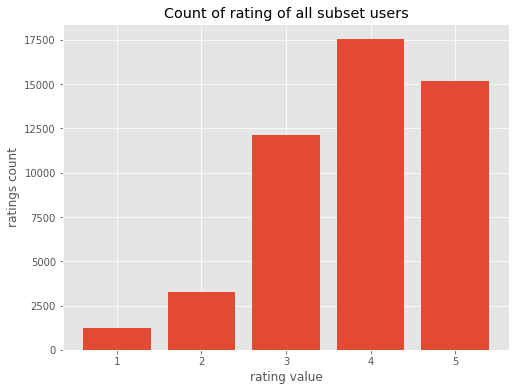

In [18]:
unique_ratings = sorted(subset_ratings_df.rating.unique())
plt.figure(figsize=(8,6))
counts = list(subset_ratings_df.rating.value_counts().sort_index().values)
_ = plt.bar(x =unique_ratings, height = counts)
plt.xticks( [1,2,3,4,5])
plt.xlabel('rating value')
plt.ylabel('ratings count')
plt.title('Count of rating of all subset users')

## Number of rating per user

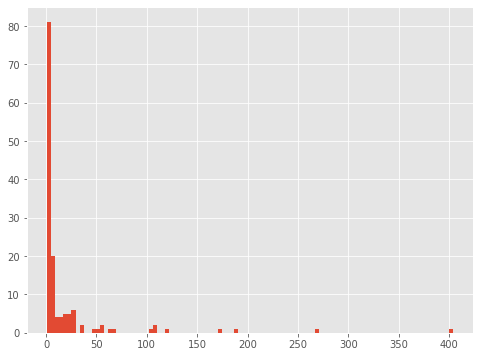

In [19]:
subset_ratings_df.groupby(by='user_id').count()['rating'].value_counts().hist(bins=100, figsize=(8,6))

In [20]:
# show less than 50 ratings

In [21]:
subset_ratings_user = subset_ratings_df.groupby(by='user_id').count()['rating'].value_counts()

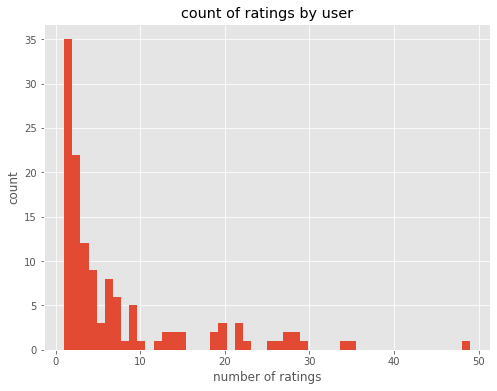

In [22]:
subset_ratings_user[subset_ratings_user < 50].hist(bins=50, figsize=(8,6))
_ = plt.title('count of ratings by user')
_ = plt.ylabel('count')
_ = plt.xlabel('number of ratings')

As can be concluded from the above plot, the greatest majority of user as less than ten ratings. 

## Distribution of mean user ratings

Each pearson has it own rating preferences. Some are very easy voters which means that rate most of books with high values or very low. On other hand, some are very selective when give max rating. Usually, this is handled by avg the user rating profile to zero. 

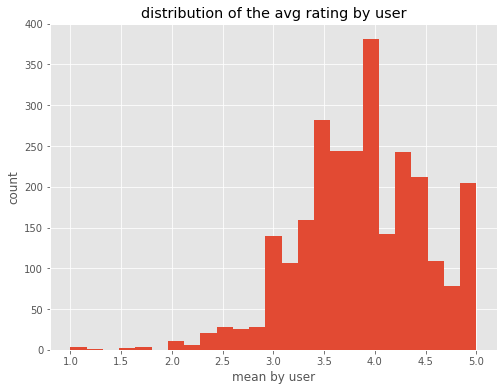

In [23]:
subset_ratings_df.groupby('user_id').mean()['rating'].hist(bins=25, figsize=(8,6))
_ = plt.title('distribution of the avg rating by user')
_ = plt.ylabel('count')
_ = plt.xlabel('mean by user')

## Distribution of ratings by book

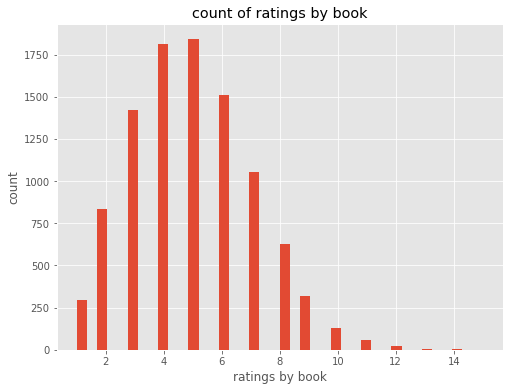

In [24]:
subset_ratings_df.groupby('book_id').count()['rating'].hist(bins=40, figsize=(8,6))
_ = plt.title('count of ratings by book')
_ = plt.ylabel('count')
_ = plt.xlabel('ratings by book')

As can be seen from the above plot, most books have between 18-22 ratings

## avg of book ratings

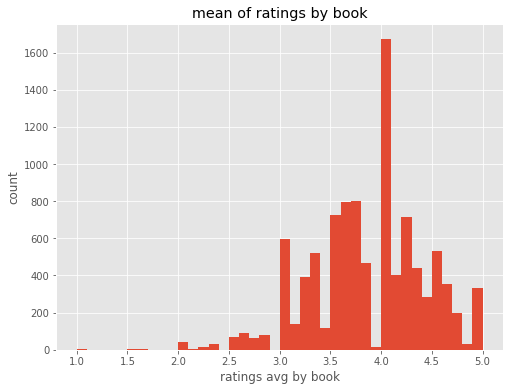

In [25]:
subset_ratings_df.groupby('book_id').mean()['rating'].hist(bins=40, figsize=(8,6))
_ = plt.title('mean of ratings by book')
_ = plt.ylabel('count')
_ = plt.xlabel('ratings avg by book')

## Top rated books

In [26]:
books = pd.read_csv('data/goodbooks/books.csv')

In [27]:
books.sort_values('average_rating', ascending=False)[['title', 'ratings_count','average_rating']]

,title,ratings_count,average_rating
3627,The Complete Calvin and Hobbes,28900,4.82
3274,"Harry Potter Boxed Set, Books 1-5 (Harry Potte...",33220,4.77
861,"Words of Radiance (The Stormlight Archive, #2)",73572,4.77
8853,Mark of the Lion Trilogy,9081,4.76
7946,ESV Study Bible,8953,4.76
...,...,...,...
9020,Lost,12534,2.80
4008,Four Blondes,22278,2.80
8006,The Finkler Question,9627,2.76
3549,The Almost Moon,28299,2.67


In [28]:
corr = books[["books_count","original_publication_year","ratings_count", "work_ratings_count",
       "work_text_reviews_count", "average_rating"]].corr()
corr.style.background_gradient(cmap='coolwarm')


,books_count,original_publication_year,ratings_count,work_ratings_count,work_text_reviews_count,average_rating
books_count,1,-0.321753,0.324235,0.333664,0.198698,-0.0698883
original_publication_year,-0.321753,1,-0.0244147,-0.0254478,0.0277841,0.0156076
ratings_count,0.324235,-0.0244147,1,0.995068,0.779635,0.0449904
work_ratings_count,0.333664,-0.0254478,0.995068,1,0.807009,0.0450416
work_text_reviews_count,0.198698,0.0277841,0.779635,0.807009,1,0.00748112
average_rating,-0.0698883,0.0156076,0.0449904,0.0450416,0.00748112,1


As we can see on the table. none of the bove features are correlated with the book rating. 
Which means that the rating depends of the book features. Which is something we expect.
A particular example is the relationship between the rating and the rating count i.e. popularity. We observe a very low corr 0.0045. This means that popular book don't need to be higly rated. 

# Business questions to keep in mind
- Does the publication of multiple book editions affect the rating?
- Do frequent raters rate differently when compared with non frequent raters?
- Are series of books best rated?
- Are the sequels better that the originals?
- Does the length of the title affects the number of ratings?
- Does having subtitles affects the books ratings?
- Does the number of author affect the book rating?


# example of a content based applications

In [29]:
subset_ratings_df

,book_id,user_id,rating
43,1,23576,4
51,1,25182,5
65,1,32635,5
96,1,51480,1
152,2,23576,5
...,...,...,...
981630,9999,28999,4
981650,9999,41235,5
981652,9999,42198,4
981694,10000,20364,5


In [30]:
# merge books and tags

In [31]:
book_tags = pd.read_csv('data/goodbooks/book_tags.csv')

In [32]:
book_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999912 entries, 0 to 999911
Data columns (total 3 columns):
goodreads_book_id    999912 non-null int64
tag_id               999912 non-null int64
count                999912 non-null int64
dtypes: int64(3)
memory usage: 22.9 MB


In [33]:
tags = pd.read_csv('data/goodbooks/tags.csv')

In [34]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34252 entries, 0 to 34251
Data columns (total 2 columns):
tag_id      34252 non-null int64
tag_name    34252 non-null object
dtypes: int64(1), object(1)
memory usage: 535.3+ KB


In [35]:
book_tags_merged = book_tags.merge(tags, on='tag_id', how='inner')

In [36]:
print('number of different tags: ',len(set(book_tags_merged.tag_name)))

number of different tags:  34252


In [37]:
to_read = pd.read_csv('data/goodbooks/to_read.csv')
to_read.head()

,user_id,book_id
0,1,112
1,1,235
2,1,533
3,1,1198
4,1,1874


In order to apply a content based recommendation engine we need to collect features from the books.
The first I am going to try, is the author name. 
To do this, we need to convert the words into a numerical representation. 
The first attempt will be to use tf-idf. That basically assigns a weight to each word based on rellative importance in the documents. 

In [38]:
uni_len = len(set((''.join(books['authors'].values.tolist())).lower().split(' ')))

In [39]:
# if we add the bigrams
bi_len = len(set(books['authors'].values))

In [40]:
# The length is bigger because I did not remove the stopwords
# Tfidf vectorizer has properties to handle that case
print('feature length for unigrams + bigrams: ', uni_len + bi_len)

feature length for unigrams + bigrams:  17536


In [41]:

tfidf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tfidf.fit_transform(books['authors'])

In [42]:
len(tfidf.get_feature_names())

14800

In [43]:
tfidf_matrix.shape

(10000, 14800)

In [44]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [45]:
# Build a 1-dimensional array with book titles
titles = books['title']
indices = pd.Series(books.index, index=books['title'])

In [46]:
indices

title
The Hunger Games (The Hunger Games, #1)                                                         0
Harry Potter and the Sorcerer's Stone (Harry Potter, #1)                                        1
Twilight (Twilight, #1)                                                                         2
To Kill a Mockingbird                                                                           3
The Great Gatsby                                                                                4
                                                                                             ... 
Bayou Moon (The Edge, #2)                                                                    9995
Means of Ascent (The Years of Lyndon Johnson, #2)                                            9996
The Mauritius Command                                                                        9997
Cinderella Ate My Daughter: Dispatches from the Frontlines of the New Girlie-Girl Culture    9998
The First Worl

In [47]:
cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [48]:
ref_title = 'The Hobbit'
idx = indices[ref_title]

In [49]:
sim_scores = list(enumerate(cosine_sim[idx]))

In [50]:
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)


In [51]:
# select top 20
sim_scores = sim_scores[1:21]
sim_scores

[(18, 1.0),
 (154, 1.0),
 (160, 1.0),
 (188, 1.0),
 (963, 1.0),
 (4975, 0.7392897825294644),
 (2308, 0.5902624351487145),
 (610, 0.5574817139590805),
 (8271, 0.4294557506655334),
 (1128, 0.4083418840881659),
 (465, 0.24362189060736741),
 (0, 0.0),
 (1, 0.0),
 (2, 0.0),
 (3, 0.0),
 (4, 0.0),
 (5, 0.0),
 (7, 0.0),
 (8, 0.0),
 (9, 0.0)]

In [52]:
book_indices = [i[0] for i in sim_scores]

In [53]:
titles.iloc[book_indices]

18      The Fellowship of the Ring (The Lord of the Ri...
154            The Two Towers (The Lord of the Rings, #2)
160     The Return of the King (The Lord of the Rings,...
188     The Lord of the Rings (The Lord of the Rings, ...
963     J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...
4975         Unfinished Tales of Númenor and Middle-Earth
2308                                The Children of Húrin
610              The Silmarillion (Middle-Earth Universe)
8271                   The Complete Guide to Middle-Earth
1128     The History of the Hobbit, Part One: Mr. Baggins
465                             The Hobbit: Graphic Novel
0                 The Hunger Games (The Hunger Games, #1)
1       Harry Potter and the Sorcerer's Stone (Harry P...
2                                 Twilight (Twilight, #1)
3                                   To Kill a Mockingbird
4                                        The Great Gatsby
5                                  The Fault in Our Stars
7             

In [54]:
books.loc[book_indices, ['title', 'authors']]

,title,authors
18,The Fellowship of the Ring (The Lord of the Ri...,J.R.R. Tolkien
154,"The Two Towers (The Lord of the Rings, #2)",J.R.R. Tolkien
160,"The Return of the King (The Lord of the Rings,...",J.R.R. Tolkien
188,"The Lord of the Rings (The Lord of the Rings, ...",J.R.R. Tolkien
963,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...,J.R.R. Tolkien
4975,Unfinished Tales of Númenor and Middle-Earth,"J.R.R. Tolkien, Christopher Tolkien"
2308,The Children of Húrin,"J.R.R. Tolkien, Christopher Tolkien, Alan Lee"
610,The Silmarillion (Middle-Earth Universe),"J.R.R. Tolkien, Christopher Tolkien, Ted Nasmith"
8271,The Complete Guide to Middle-Earth,"Robert Foster, J.R.R. Tolkien"
1128,"The History of the Hobbit, Part One: Mr. Baggins","John D. Rateliff, J.R.R. Tolkien"


As I expected, the most similar books, are the ones, that contain, J.R.R Tolkien as author. 

## using tags to create recommendations

In [55]:
book_tags_merged.groupby('goodreads_book_id')['tag_name'].count()

goodreads_book_id
1           100
2           100
3           100
5           100
6           100
           ... 
31538647    100
31845516    100
32075671    100
32848471    100
33288638    100
Name: tag_name, Length: 10000, dtype: int64

In [56]:
# As can be seen each book as 100 tags
# To build my matrix I need to concatenate all the tags for each book

In [57]:
tmp_df = book_tags_merged.groupby('goodreads_book_id')['tag_name'].apply(lambda x: ' '.join(x)).reset_index()

In [58]:
tmp_df.head()

,goodreads_book_id,tag_name
0,1,to-read fantasy favorites currently-reading yo...
1,2,to-read fantasy favorites currently-reading yo...
2,3,to-read fantasy favorites currently-reading yo...
3,5,to-read fantasy favorites currently-reading yo...
4,6,to-read fantasy young-adult fiction harry-pott...


In [59]:
# now we need to calculate TF-IDF on the tags

In [60]:
tfidf_matrix = tfidf.fit_transform(tmp_df['tag_name'])

In [61]:
tfidf_matrix.shape

(10000, 144268)

In [62]:
cosine_tags = linear_kernel(tfidf_matrix, tfidf_matrix)

In [63]:
cosine_tags.shape

(10000, 10000)

In [64]:
cosine_tags

array([[1.        , 0.68192026, 0.91036408, ..., 0.1007038 , 0.05800547,
        0.0611492 ],
       [0.68192026, 1.        , 0.63115993, ..., 0.09496954, 0.04120744,
        0.05587359],
       [0.91036408, 0.63115993, 1.        , ..., 0.09211697, 0.05323224,
        0.06010517],
       ...,
       [0.1007038 , 0.09496954, 0.09211697, ..., 1.        , 0.19470526,
        0.11254203],
       [0.05800547, 0.04120744, 0.05323224, ..., 0.19470526, 1.        ,
        0.21665975],
       [0.0611492 , 0.05587359, 0.06010517, ..., 0.11254203, 0.21665975,
        1.        ]])

In [65]:
# now we need to sort by similarity
def reccommend_books(ref_book):
    idx = indices[ref_book]
    sim_scores = list(enumerate(cosine_tags[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # select top 20
    sim_scores = sim_scores[1:21]
    book_indices = [i[0] for i in sim_scores]
    return titles.iloc[book_indices].index

In [66]:
ref_title = 'The Hobbit'
titles_index = reccommend_books(ref_title)

In [67]:
books_all_info = book_tags_merged.merge(books, left_on='goodreads_book_id', right_on= 'book_id', how='inner')


In [68]:
books_all_info.head()

,goodreads_book_id,tag_id,count,tag_name,id,book_id,best_book_id,work_id,books_count,isbn,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,30574,167697,to-read,27,1,1,41335427,275,439785960,...,1678823,1785676,27520,7308,21516,136333,459028,1161491,https://images.gr-assets.com/books/1361039191m...,https://images.gr-assets.com/books/1361039191s...
1,1,11305,37174,fantasy,27,1,1,41335427,275,439785960,...,1678823,1785676,27520,7308,21516,136333,459028,1161491,https://images.gr-assets.com/books/1361039191m...,https://images.gr-assets.com/books/1361039191s...
2,1,11557,34173,favorites,27,1,1,41335427,275,439785960,...,1678823,1785676,27520,7308,21516,136333,459028,1161491,https://images.gr-assets.com/books/1361039191m...,https://images.gr-assets.com/books/1361039191s...
3,1,8717,12986,currently-reading,27,1,1,41335427,275,439785960,...,1678823,1785676,27520,7308,21516,136333,459028,1161491,https://images.gr-assets.com/books/1361039191m...,https://images.gr-assets.com/books/1361039191s...
4,1,33114,12716,young-adult,27,1,1,41335427,275,439785960,...,1678823,1785676,27520,7308,21516,136333,459028,1161491,https://images.gr-assets.com/books/1361039191m...,https://images.gr-assets.com/books/1361039191s...


In [69]:
books.loc[titles_index , ['title', 'authors']]

,title,authors
1276,The Case for Christ,Lee Strobel
0,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins
2,"Twilight (Twilight, #1)",Stephenie Meyer
3,To Kill a Mockingbird,Harper Lee
4,The Great Gatsby,F. Scott Fitzgerald
3890,"Shoe Addicts Anonymous (Shoe Addict, #1)",Beth Harbison
1,Harry Potter and the Sorcerer's Stone (Harry P...,"J.K. Rowling, Mary GrandPré"
5,The Fault in Our Stars,John Green
5686,The Readers of Broken Wheel Recommend,"Katarina Bivald, Alice Menzies"
159,Great Expectations,Charles Dickens


In [70]:
len(titles_index)

20

In [71]:
tmp_df.head()

,goodreads_book_id,tag_name
0,1,to-read fantasy favorites currently-reading yo...
1,2,to-read fantasy favorites currently-reading yo...
2,3,to-read fantasy favorites currently-reading yo...
3,5,to-read fantasy favorites currently-reading yo...
4,6,to-read fantasy young-adult fiction harry-pott...


In [72]:
books_full_tags = books.merge(tmp_df, left_on='book_id', right_on='goodreads_book_id')

In [73]:
books_full_tags['tags_authors'] = books_full_tags['authors'] + ' ' + books_full_tags['tag_name']

In [74]:
tfidf_matrix = tfidf.fit_transform(books_full_tags['tags_authors'])
cosine_tags = linear_kernel(tfidf_matrix, tfidf_matrix)

In [75]:
ref_title = 'The Hobbit'
titles_index = reccommend_books(ref_title)
books.loc[titles_index , ['title', 'authors']]

,title,authors
188,"The Lord of the Rings (The Lord of the Rings, ...",J.R.R. Tolkien
154,"The Two Towers (The Lord of the Rings, #2)",J.R.R. Tolkien
160,"The Return of the King (The Lord of the Rings,...",J.R.R. Tolkien
18,The Fellowship of the Ring (The Lord of the Ri...,J.R.R. Tolkien
610,The Silmarillion (Middle-Earth Universe),"J.R.R. Tolkien, Christopher Tolkien, Ted Nasmith"
4975,Unfinished Tales of Númenor and Middle-Earth,"J.R.R. Tolkien, Christopher Tolkien"
2308,The Children of Húrin,"J.R.R. Tolkien, Christopher Tolkien, Alan Lee"
963,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...,J.R.R. Tolkien
465,The Hobbit: Graphic Novel,"Chuck Dixon, J.R.R. Tolkien, David Wenzel, Sea..."
8271,The Complete Guide to Middle-Earth,"Robert Foster, J.R.R. Tolkien"


In [76]:
# As can be seen the features created using the tags and the authors deliver resuts that seem much more consistent.

In [152]:
ref_title = 'The Brethren'
titles_index = reccommend_books(ref_title)
books.loc[titles_index , ['title', 'authors']]

,title,authors
1732,The Summons,John Grisham
342,The Runaway Jury,John Grisham
962,The Partner,John Grisham
1300,The Broker,John Grisham
1036,The Street Lawyer,John Grisham
1056,The Testament,John Grisham
1406,The King of Torts,John Grisham
1901,The Associate,John Grisham
595,The Rainmaker,John Grisham
280,The Pelican Brief,John Grisham


Further studies on this topic would require the usage of ohter features. Or other models. But the idea is still the same cluster the books by similarity. 
Can be used metrics like:
 - euclidean distance
 - pearson correlation
 

## Collaborative filtering implementation

Collaborative filtering works by selecting the most similar users and recommend the same taht previous users saw. 
Typically we have a simialr matrix 


In [78]:
##        book_id
## user_id  1  2  3  4  5
##       1 NA NA  4 NA NA
##       2  2  1 NA NA NA
##       3 NA NA  3 NA  3

# This are very sparse matrixes

In [79]:
# Where we have a rating for each book assign by each user. This two rating can be implicit or explicit 
# as discussed in the intro above

## First step: Shape data

In [80]:
ratings = pd.read_csv('data/goodbooks/ratings.csv')

In [141]:
# apply subset of users
users_subset = users_subset + [17329]
ratings = ratings.loc[ratings.user_id.isin(users_subset),:]

In [143]:
ratings.loc[ratings.user_id == 17329,:]

,book_id,user_id,rating


In [132]:
ratings_pivot = pd.pivot_table(ratings, values='rating', index=['user_id'],
                    columns=['book_id'], aggfunc=np.mean)

In [133]:
ratings_pivot.shape

(2671, 9938)

## 2nd step: Find similar users

In [134]:
# before calculating the similar users, we need to normalize the the ratings.

In [135]:
ratings_normed = ratings_pivot - ratings_pivot.mean(axis=1)

In [136]:
ratings_normed.head()

,1,2,3,4,5,6,7,8,9,10,...,53285,53304,53340,53349,53350,53355,53391,53406,53409,53413
user_id,,,,,,,,,,,,,,,,,,,,,
39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [137]:
ratings_normed = ratings_normed.fillna(0)

In [138]:
user_sim = linear_kernel(ratings_normed, ratings_normed)

In [150]:
user_sim

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 2.25      , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.12456747,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [140]:
# Now lets search for the user most similar with user #139
user_id = 17329
idx = list(ratings_normed.index.values).index(user_id)
print(idx)

ValueError: 17329 is not in list

In [121]:
set(user_sim[])

{0.0, 0.75, 2.25}

In [114]:
# now we need to sort by similarity
def similar_users(user_id, cousine_matrix):
    idx = list(ratings_normed.index.values).index(user_id)
    sim_scores = list(enumerate(cousine_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # select top 20
    sim_scores = sim_scores[1:21]
    similar_users = [i[0] for i in sim_scores]
    return similar_users

In [115]:
similar_users(139,user_sim)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]